In [1]:
import pandas as pd

In [2]:
fake_news = pd.read_csv('/content/Fake.csv')
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
true_news = pd.read_csv('/content/True.csv')
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake_news['label'] = 'FAKE'
true_news['label'] = 'REAL'

In [5]:
df = pd.concat([fake_news, true_news],axis=0).reset_index(drop=True)
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",FAKE
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",FAKE
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",FAKE
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",FAKE
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",FAKE


In [6]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",FAKE
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",REAL
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",REAL
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",FAKE
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",REAL


In [7]:
df['label'].value_counts()

,count
label,
FAKE,23481
REAL,21417


In [14]:
import spacy

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
i = 0
def process_text(text):
    global i
    print(f'{i}\n')
    i += 1
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha and len(token) > 2]
    return " ".join(tokens)

In [15]:
df['clean_text'] = df['text'].apply(process_text)

Streaming output truncated to the last 5000 lines.
42398

42399

42400

42401

42402

42403

42404

42405

42406

42407

42408

42409

42410

42411

42412

42413

42414

42415

42416

42417

42418

42419

42420

42421

42422

42423

42424

42425

42426

42427

42428

42429

42430

42431

42432

42433

42434

42435

42436

42437

42438

42439

42440

42441

42442

42443

42444

42445

42446

42447

42448

42449

42450

42451

42452

42453

42454

42455

42456

42457

42458

42459

42460

42461

42462

42463

42464

42465

42466

42467

42468

42469

42470

42471

42472

42473

42474

42475

42476

42477

42478

42479

42480

42481

42482

42483

42484

42485

42486

42487

42488

42489

42490

42491

42492

42493

42494

42495

42496

42497

42498

42499

42500

42501

42502

42503

42504

42505

42506

42507

42508

42509

42510

42511

42512

42513

42514

42515

42516

42517

42518

42519

42520

42521

42522

42523

42524

42525

42526

42527

42528

42529

42530

42531

42532

4253

In [16]:
df.head()

,title,text,subject,date,label,clean_text
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",FAKE,century wire say ben stein reputable professor...
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",REAL,washington reuters president donald trump remo...
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",REAL,reuters puerto rico governor ricardo rossello ...
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",FAKE,monday donald trump embarrass country accident...
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",REAL,glasgow scotland reuters presidential candidat...


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [18]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']

In [19]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=300, random_state=42)
X_reduced = svd.fit_transform(X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, stratify=y, random_state=42
)

In [21]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=15, metric='cosine')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=15)

              precision    recall  f1-score   support

        FAKE       0.92      0.89      0.90      4696
        REAL       0.88      0.92      0.90      4284

    accuracy                           0.90      8980
   macro avg       0.90      0.90      0.90      8980
weighted avg       0.90      0.90      0.90      8980



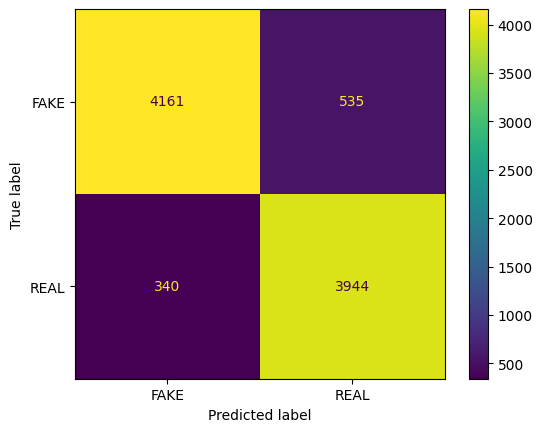

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predictions
y_pred = knn.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

ROC AUC Score: 0.9667941566177862


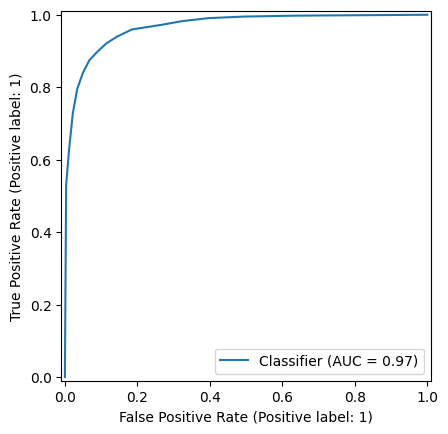

In [23]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Convert to binary
y_test_bin = y_test.map({'REAL': 1, 'FAKE': 0})
y_prob = knn.predict_proba(X_test)[:, 1]

print("ROC AUC Score:", roc_auc_score(y_test_bin, y_prob))
RocCurveDisplay.from_predictions(y_test_bin, y_prob)


In [24]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_neighbors': [3, 5, 10, 15, 20],
    'metric': ['cosine', 'euclidean']
}

grid = GridSearchCV(KNeighborsClassifier(), params, cv=3, scoring='f1_macro')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)


Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3}
